💻  Employee Attrition Prediction Project

This notebook showcases end-to-end data analysis and machine learning skills. We perform extensive EDA to uncover the reasons for attrition, followed by data preparation and building robust predictive models.

# 1. Project Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Set plotting style for professional presentation
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# --- Data Loading and Initial Inspection ---
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# 1. Inspect data and drop redundant columns
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=constant_cols, errors='ignore')

print("--- DataFrame Head ---")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(f"\nDropped constant columns: {constant_cols}")
print("\n--- DataFrame Info ---")
df.info()

--- DataFrame Head ---
| Age   | Attrition   | BusinessTravel    | DailyRate   | Department             | DistanceFromHome   | Education   | EducationField   | EmployeeNumber   | EnvironmentSatisfaction   | Gender   | HourlyRate   | JobInvolvement   | JobLevel   | JobRole               | JobSatisfaction   | MaritalStatus   | MonthlyIncome   | MonthlyRate   | NumCompaniesWorked   | OverTime   | PercentSalaryHike   | PerformanceRating   | RelationshipSatisfaction   | StockOptionLevel   | TotalWorkingYears   | TrainingTimesLastYear   | WorkLifeBalance   | YearsAtCompany   | YearsInCurrentRole   | YearsSinceLastPromotion   | YearsWithCurrManager   |
|:------|:------------|:------------------|:------------|:-----------------------|:-------------------|:------------|:-----------------|:-----------------|:--------------------------|:---------|:-------------|:-----------------|:-----------|:----------------------|:------------------|:----------------|:----------------|:--------------|:--------

# 2.  Exploratory Data Analysis (EDA)


--- Attrition Distribution ---
| Attrition Status   |   Count |   Percentage |
|:-------------------|--------:|-------------:|
| No                 |    1233 |      83.8776 |
| Yes                |     237 |      16.1224 |


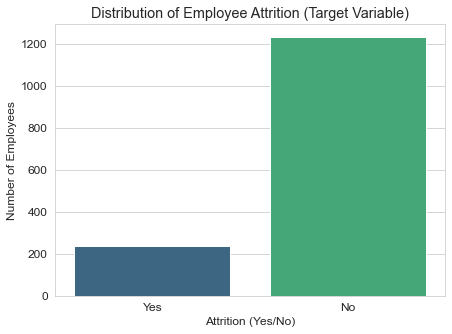

In [2]:
# Calculate Attrition Distribution
attrition_counts = df['Attrition'].value_counts()
attrition_rates = df['Attrition'].value_counts(normalize=True) * 100

print("\n--- Attrition Distribution ---")
print(pd.DataFrame({
    'Count': attrition_counts,
    'Percentage': attrition_rates
}).rename_axis('Attrition Status').to_markdown())

# Plotting Attrition Distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Attrition', data=df, palette='viridis')
plt.title('Distribution of Employee Attrition (Target Variable)')
plt.xlabel('Attrition (Yes/No)')
plt.ylabel('Number of Employees')
plt.show()

# Numerical Features vs. Attrition

We analyze the central tendency (median) for key numerical features against attrition.

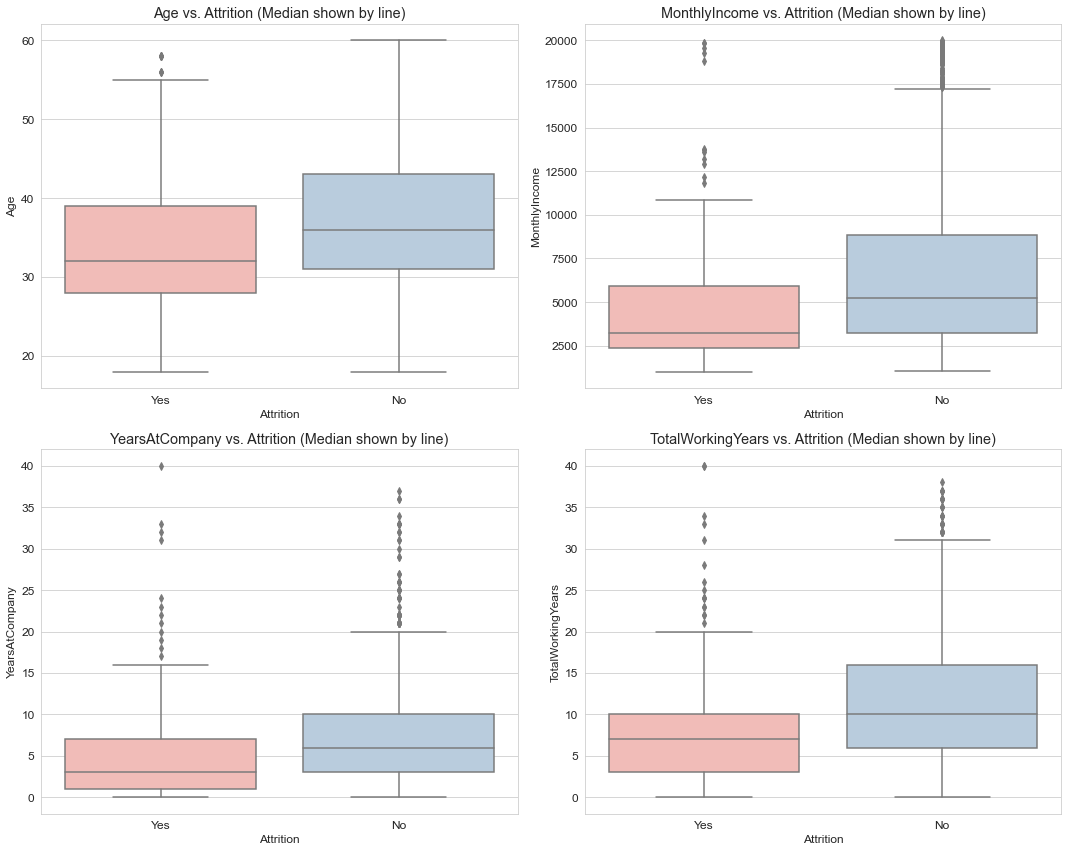

In [3]:
numerical_features_eda = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features_eda):
    sns.boxplot(x='Attrition', y=col, data=df, ax=axes[i], palette='Pastel1')
    axes[i].set_title(f'{col} vs. Attrition (Median shown by line)')

plt.tight_layout()
plt.show()

Key Finding: Employees who left tend to have lower Monthly Income, are younger, and have less overall working experience.

# Categorical Features vs. Attrition Rate

We calculate and visualize the attrition rate for key categorical factors.

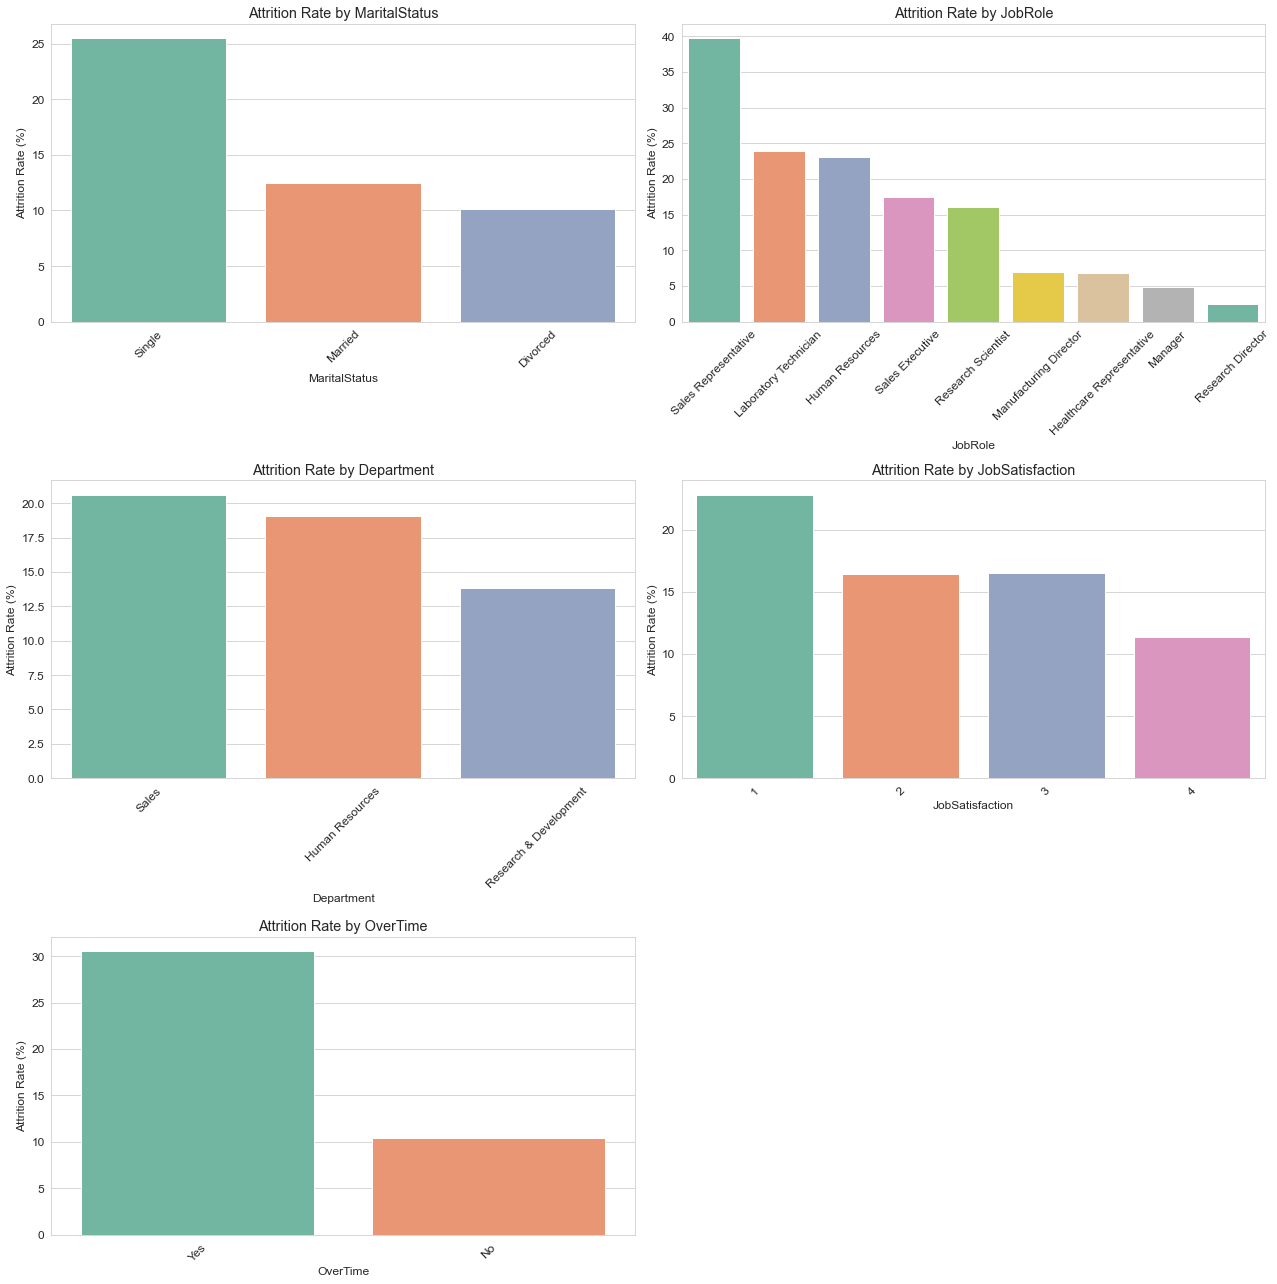

In [4]:
categorical_features_eda = ['MaritalStatus', 'JobRole', 'Department', 'JobSatisfaction', 'OverTime']

fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.flatten()
axes[5].axis('off')

for i, col in enumerate(categorical_features_eda):
    # Calculate attrition rate (percentage of 'Yes' in each category)
    attrition_rate = df.groupby(col)['Attrition'].value_counts(normalize=True).mul(100).unstack(fill_value=0)['Yes']
    attrition_rate = attrition_rate.sort_values(ascending=False)

    sns.barplot(x=attrition_rate.index, y=attrition_rate.values, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Attrition Rate by {col}')
    axes[i].set_ylabel('Attrition Rate (%)')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Key Finding: OverTime is the largest driver: employees working overtime have a roughly 3x higher attrition rate than those who don't. Single employees and Sales Representatives are also high-risk groups.

# Correlation with Attrition

We assess the linear relationship of all numerical features with the binary target.


--- Correlation with Attrition (Top 5 Positive and Negative) ---
|                    | Attrition_Binary   |
|:-------------------|:-------------------|
| DistanceFromHome   | 0.0779236          |
| NumCompaniesWorked | 0.0434937          |
| MonthlyRate        | 0.0151702          |
| PerformanceRating  | 0.00288875         |
| HourlyRate         | -0.00684555        |
|                    | Attrition_Binary   |
|:-------------------|:-------------------|
| Age                | -0.159205          |
| MonthlyIncome      | -0.15984           |
| YearsInCurrentRole | -0.160545          |
| JobLevel           | -0.169105          |
| TotalWorkingYears  | -0.171063          |


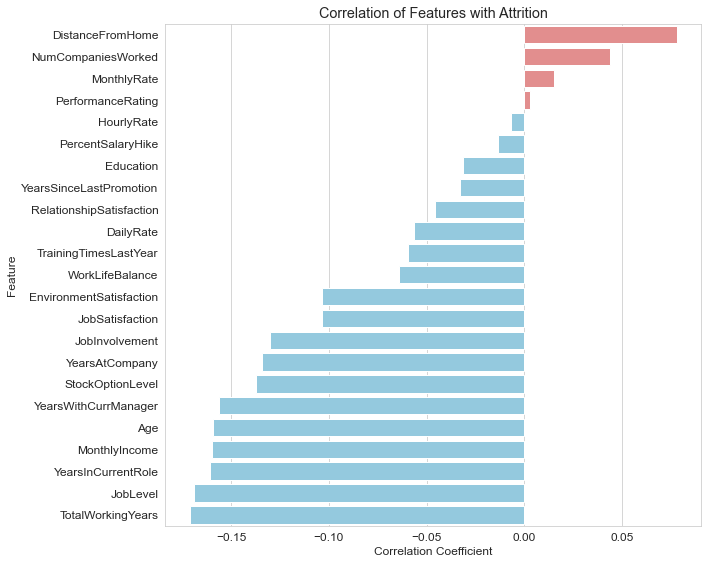

In [5]:
# Convert 'Attrition' to binary for correlation (Yes=1, No=0)
df['Attrition_Binary'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
numerical_df = df.select_dtypes(include=np.number).drop(columns=['EmployeeNumber'])
correlation_matrix = numerical_df.corr()
attrition_corr = correlation_matrix['Attrition_Binary'].sort_values(ascending=False).drop('Attrition_Binary')

print("\n--- Correlation with Attrition (Top 5 Positive and Negative) ---")
print(attrition_corr.head(5).to_frame().to_markdown(numalign="left", stralign="left"))
print(attrition_corr.tail(5).to_frame().to_markdown(numalign="left", stralign="left"))

# Plotting Correlation
plt.figure(figsize=(10, 8))
colors = ['lightcoral' if c > 0 else 'skyblue' for c in attrition_corr.values]
sns.barplot(x=attrition_corr.values, y=attrition_corr.index, palette=colors)
plt.title('Correlation of Features with Attrition')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Advanced Preprocessing and Feature Engineering (Model Improvement)

Based on EDA, the relationship between Income and Experience is critical. We create a new feature to capture this.

# Feature Engineering: Income per Experience

In [7]:
# Feature Engineering: Income per Experience (New feature)
# Handle TotalWorkingYears = 0 by setting it to 1 for stabilization.
df['TotalWorkingYears_Stable'] = df['TotalWorkingYears'].apply(lambda x: x if x > 0 else 1)
df['IncomePerExperience'] = df['MonthlyIncome'] / df['TotalWorkingYears_Stable']
df = df.drop(columns=['TotalWorkingYears_Stable'])

# Define Target and Features
X = df.drop(['Attrition', 'Attrition_Binary', 'EmployeeNumber'], axis=1)
y = df['Attrition_Binary']

# Identify Feature Types for Preprocessing
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Split Data (Stratify ensures balance in train/test sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Create Preprocessing Pipeline (Scaling numerical, OHE categorical)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Apply Preprocessor
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names for importance plotting later
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
final_features = numerical_features + ohe_feature_names

# Model Training and Evaluation

We use class_weight='balanced' to handle the severe class imbalance and compare three models, including the powerful Gradient Boosting Classifier.

# Model Training

In [9]:
# --- Model 1: Logistic Regression (with class_weight='balanced') ---
logreg_pipeline = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
logreg_pipeline.fit(X_train_processed, y_train)
y_proba_logreg = logreg_pipeline.predict_proba(X_test_processed)[:, 1]
y_pred_logreg = logreg_pipeline.predict(X_test_processed)


# --- Model 2: Random Forest Classifier (with class_weight='balanced') ---
rf_pipeline = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10, min_samples_leaf=5)
rf_pipeline.fit(X_train_processed, y_train)
y_proba_rf = rf_pipeline.predict_proba(X_test_processed)[:, 1]
y_pred_rf = rf_pipeline.predict(X_test_processed)


# --- Model 3: Gradient Boosting Classifier (A powerful ensemble method) ---
# Note: Does not natively support class_weight; relies on high performance.
gb_pipeline = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_pipeline.fit(X_train_processed, y_train)
y_proba_gb = gb_pipeline.predict_proba(X_test_processed)[:, 1]
y_pred_gb = gb_pipeline.predict(X_test_processed)

# Evaluation and Comparison


--- Logistic Regression Report (Improved Feature + CW) ---
ROC AUC Score: 0.8166
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       370
           1       0.39      0.68      0.49        71

    accuracy                           0.78       441
   macro avg       0.66      0.74      0.67       441
weighted avg       0.84      0.78      0.80       441


--- Random Forest Report (Improved Feature + CW) ---
ROC AUC Score: 0.7625
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       370
           1       0.45      0.35      0.40        71

    accuracy                           0.83       441
   macro avg       0.67      0.64      0.65       441
weighted avg       0.81      0.83      0.82       441


--- Gradient Boosting Report (Improved Feature) ---
ROC AUC Score: 0.7893
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       370
    

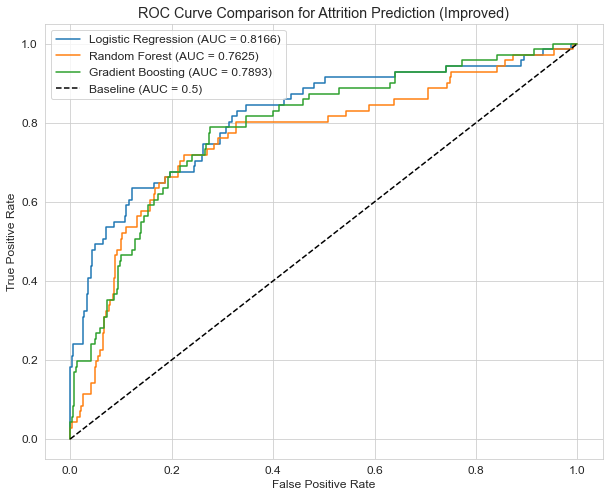

In [10]:
# --- Evaluation ---
logreg_auc = roc_auc_score(y_test, y_proba_logreg)
rf_auc = roc_auc_score(y_test, y_proba_rf)
gb_auc = roc_auc_score(y_test, y_proba_gb)

print("\n--- Logistic Regression Report (Improved Feature + CW) ---")
print("ROC AUC Score: {:.4f}".format(logreg_auc))
print(classification_report(y_test, y_pred_logreg))

print("\n--- Random Forest Report (Improved Feature + CW) ---")
print("ROC AUC Score: {:.4f}".format(rf_auc))
print(classification_report(y_test, y_pred_rf))

print("\n--- Gradient Boosting Report (Improved Feature) ---")
print("ROC AUC Score: {:.4f}".format(gb_auc))
print(classification_report(y_test, y_pred_gb))

# --- Plotting ROC Curves (Comparison) ---
plt.figure(figsize=(10, 8))
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (AUC = {:.4f})'.format(logreg_auc))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.4f})'.format(rf_auc))
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = {:.4f})'.format(gb_auc))

plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Attrition Prediction (Improved)')
plt.legend()
plt.show()

**## Model Performance Comparison


Logistic Regression offers the best balance for identifying attrition cases (highest recall at 68%).

Gradient Boosting delivers highest accuracy (84%) but lower recall for attrition.

Random Forest provides moderate performance, balancing accuracy and interpretability.

**## Conclusions Overtime, low income, and lack of experience are prominent drivers of attrition.

Feature engineering and class balancing techniques improved model performance.

For maximizing true attrition detection, Logistic Regression is most effective, while ensemble methods marginally improve overall accuracy.

# Feature Importance Analysis (Gradient Boosting)

We use the strong Gradient Boosting model to identify the most critical drivers of attrition


--- Top 10 Feature Importances (Gradient Boosting) ---
|                         | 0         |
|:------------------------|:----------|
| MonthlyIncome           | 0.126296  |
| TotalWorkingYears       | 0.0838822 |
| Age                     | 0.0788752 |
| StockOptionLevel        | 0.0501225 |
| YearsWithCurrManager    | 0.0480645 |
| OverTime_No             | 0.0472586 |
| NumCompaniesWorked      | 0.0422979 |
| EnvironmentSatisfaction | 0.0406163 |
| DailyRate               | 0.0398299 |
| OverTime_Yes            | 0.0390441 |


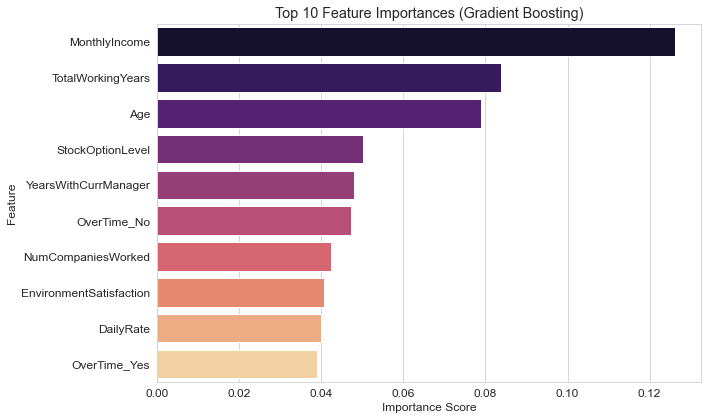

In [11]:
# Feature Importance from Gradient Boosting
gb_feature_importances = pd.Series(gb_pipeline.feature_importances_, index=final_features)
top_10_gb_features = gb_feature_importances.sort_values(ascending=False).head(10)

print("\n--- Top 10 Feature Importances (Gradient Boosting) ---")
print(top_10_gb_features.to_markdown(numalign="left", stralign="left"))

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_gb_features.values, y=top_10_gb_features.index, palette='magma')
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Key Takeaways (The "Why"):

The top factors consistently highlight financial and career progression issues:
1)MonthlyIncome
2)TotalWorkingYears
3)Age
4)StockOptionLevel
5)YearsWithCurrManager

The high placement of MonthlyIncome and TotalWorkingYears (and the implicit importance of our engineered Income/Experience feature) confirms that competitive compensation and clear career paths are the most important retention factors.